### Modeling the Energy Demand for DAC Monolith Systems

In [2]:
# Packages:
import numpy as np
from numpy import exp
import pandas as pd
import math

import CoolProp.CoolProp as CP
import matplotlib.pyplot as plt
from fipy import CellVariable, FaceVariable, Grid1D, TransientTerm, DiffusionTerm, ConvectionTerm


In [3]:
# Data Sets:
HousData = pd.read_csv('HoustonClimateData.csv') # hourly
MonRunStatus = pd.read_csv('DAC Run Scenarios/1yrRun_MonStampiBombelli.csv') # 10 min

# Expand climate data - assumes conditions within hour don't change
HousData_exp = HousData.loc[HousData.index.repeat(6)].reset_index(drop=True) # 10 min

print(HousData)
print(MonRunStatus)

      WindSpeed  SoilTemperature  AirTemperature   Radiation  SpecificHumidity
0      8.070086       289.373413      287.725281    0.000000          0.008639
1      8.185447       288.695312      287.377014    0.000000          0.008467
2      7.539393       288.091400      286.852112    0.000000          0.008555
3      7.047758       287.534851      285.859131    0.000000          0.008742
4      6.486834       287.088898      285.580261    0.000000          0.008990
...         ...              ...             ...         ...               ...
8755        NaN       286.576965      293.150391  594.500000          0.007796
8756        NaN       287.609894      293.634216  485.750000          0.007903
8757        NaN       288.276459      293.534821  325.500000          0.008079
8758        NaN       288.426178      292.625427  138.375000          0.009105
8759        NaN       287.778259      289.126160    7.400391          0.009399

[8760 rows x 5 columns]
              hour  minute 

In [4]:
## Functions:
# Functions to calculate work (W); Stampi-Bombelli Paper
def fan_work(eta_fan, V_flow, P_drop, t_fan):
    W_fan = (1 / eta_fan) * V_flow * (P_drop) * t_fan
    return W_fan

def comp_work(eta_comp, n, R, T, pH, pL, t_comp):
    W_comp = (1 / eta_comp) * n * R * T * np.log(pH / pL) * t_comp
    return W_comp

def total_work(W_comp, W_fan):
    W_total = W_comp + W_fan
    return W_total
    
# Function to calculate heat transfer (Q); Stampi-Bombelli Paper
def heat_transfer(h_W, Twf, Tw, r, L, t_heat):
    Q = h_W * (Twf - Tw) * 2 * np.pi * r * L * t_heat
    return Q

# Function to calculate Relative Humidity from Specific Humidity
def get_RH(Temp, SpecHum):
    Ps = 611.3 * math.e ** (5417.1 * (1 / 273.15 - 1 / Temp)) #Saturation Vapor Pressure (Clausius-Clapeyron equation)
    RH = 100 * (SpecHum * 461.5 * Temp / Ps)
    return RH

# Inputs to Toth Equation:
def ns(T): # S2 Stampi-Bombelli
    return ns0 * np.exp(chi * (1 - T / T0))
    
def b(T): # S3 Stampi-Bombelli
    return b0 * np.exp((deltaH0 / (R_mol * T0)) * ((T0 / T) - 1))

def t(T): # S4 Stampi-Bombelli
    return t0 + alpha * (1 - T0 / T) 

# Toth Equation:
def find_q_star(p_CO2, T): # S1 Stampi-Bombelli
    ns_val = ns(T)
    b_val = b(T)
    t_val = t(T)
    numerator = ns_val * b_val * p_CO2
    denominator = (1 + (b_val * p_CO2)**t_val)**(1 / t_val)
    return numerator / denominator # mol capacity CO2 / kg sorbent

In [5]:
## Variables & Inputs:
# Climate Data Inputs
TempsHourly = HousData_exp['AirTemperature'].values # K
SpecHumidity = HousData_exp['SpecificHumidity'].values # kg/m3
Tc = 298 # K, constant temperature

# System Variables
v = 0.8 #m/s Average feed velocity, Stampi-Bombelli et al
mu = CP.PropsSI('V','P',101325,'T',TempsHourly,'air') #Pa*s gaseous dynamic viscosity
mu_c = CP.PropsSI('V','P',101325,'T',Tc,'air') #Pa*s constant viscosity

rho = CP.PropsSI('D','P',101325,'T',TempsHourly,'air') #kg/m3 density of dry air
rho_c = CP.PropsSI('D','P',101325,'T',Tc,'air') #kg/m3 constant density

Twf = 373.15  # K, Heat of regeneration
Tw = TempsHourly # K, Column wall temperature (this is outdoor temperature)

R = 287 #J/kg(air)*K
R_CO2 = 188.92 #J/kg*K
R_mol = 8.314 # J/mol·K
T = TempsHourly  # K, Air temperature

pH = 100000 # Pa, Inital pressure (1 bar)
pL = 1000  # Pa, Vacuum pressure (Stampi-Bombelli)

eta_fan = 0.5  # Efficiency of blower; Stampi-Bombelli
eta_comp = 0.3  # Efficiency of compressor; Stampi-Bombelli


In [215]:
# Monolith Scenario: Stampi-Bombelli Paper
mull_pore_size = 0.00002 # m (20µm)
mull_porosity = 0.45
mull_rho_s = 3030 # kg/m3 Material density (without voids)
mull_rho_p = 1666 # kg/m3 Material density (including voids)

tri_pore_size = 1.4E-8 # m (14nm)
tri_porosity = 0.71
tri_rho_s = 3600 # kg/m3 Material density (without voids)
tri_rho_p = 1044 # kg/m3 Material density (including voids)

N = 196 # number of cells
CPSI = 100 # roughly

L = 0.4 # m
W = 0.0354 # m
D = 0.04 # m, equivalent diameter
r = D/2 # m, radius

w2 = 0.0025 # m, 2.5mm cell width
w1 = 0.3 * w2 # m, range from 0.3-0.9, channel width
w_wall = w2 - w1 # m, wall thickness, should range from 0.25-1.8mm

V = np.pi * r**2 * L # m3, volume(cylinder)
V_chan = w1**2 * L # m3, channel volume
V_wall = V - N*V_chan # m3, wall volume

omega = 1.0 # loading, range from 10-100%, kgTRI-al / kg total
rho_s = (omega / tri_rho_s + (1 - omega) / mull_rho_s) ** -1 # wall material density (without voids)
rho_p = (omega / tri_rho_p + (1 - omega) / mull_rho_p) ** -1 # wall desnity (including voids)

rho_bed = rho_p * V_wall / V # bed density
epsilon = 1 - rho_bed / rho_p # bed porosity
u = v / epsilon # m/s interstitial velocity
h_L = 26 # W/K*m2, wall-ambient heat transfer coefficient
h_W = 7 # W/K*m2, column wall heat transfer coefficient


In [217]:
# Monolith CO2 adsorption equilibrium:
T0 = 298 # K, reference temperature for Toth parameters
ns0 = 1.025 # mol/kg Toth sorbent maximum capacity at reference temperature
b0 = 6757 # 1/kPa Toth affinity coefficient at reference temperature
t0 = 0.231 # Toth exponent (heterogeneity parameter) at reference temperature

deltaH0 = 77000 # J/mol isosteric heat of adsorption (how much energy is released when CO2 binds to sorbent) (exothermic) Grossmann et al 

chi = 4.66E-10 # Temperature adjustment factor for ns(T) (0 means no temperature dependence of maximum capacity)
alpha = 0.215 # Temperature adjustment factor for t(T)

CO2_conc = 430 # ppm
pCO2_air = pH/1000 * (CO2_conc/1000000) # kPa
c_CO2 = (pCO2_air * 1000) / (R_mol * Tc) # mol/m3
c_CO2_c = (pCO2_air * 1000) / (R_mol * Tc) # mol/m3

q_star_ads = find_q_star(pCO2_air, T)
q_star_mon = omega * q_star_ads # monolith includes non-adsorbing support (mullite), so q* per total monolith mass is ω * q*sorbent
q_star_ads_c = find_q_star(pCO2_air, Tc)
q_star_mon_c = omega * q_star_ads_c

pCO2_des = 1 # KPa "CO2 is the only species desorbing during regeneration, its molar fraction rapidly reaches 1, with its partial pressure matching the vacuum level." - Stampi-Bombelli
q_star_des = find_q_star(pCO2_des, 373.15) * omega


deltaq_star = q_star_mon - q_star_des


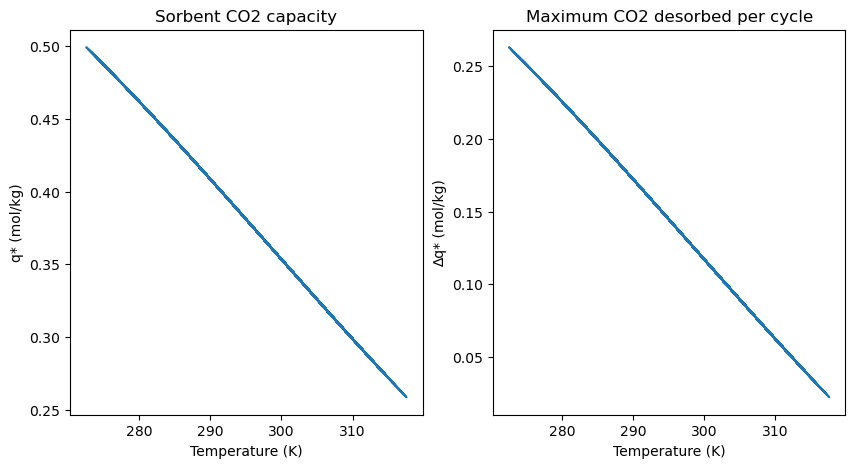

In [219]:
# Plotting q* and ∆q* curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(T, q_star_mon)

plt.ylabel('q* (mol/kg)')
plt.xlabel('Temperature (K)')
plt.title('Sorbent CO2 capacity')

plt.subplot(1, 2, 2)
plt.plot(T, deltaq_star)

plt.ylabel('∆q* (mol/kg)')
plt.xlabel('Temperature (K)')
plt.title('Maximum CO2 desorbed per cycle')
plt.show()

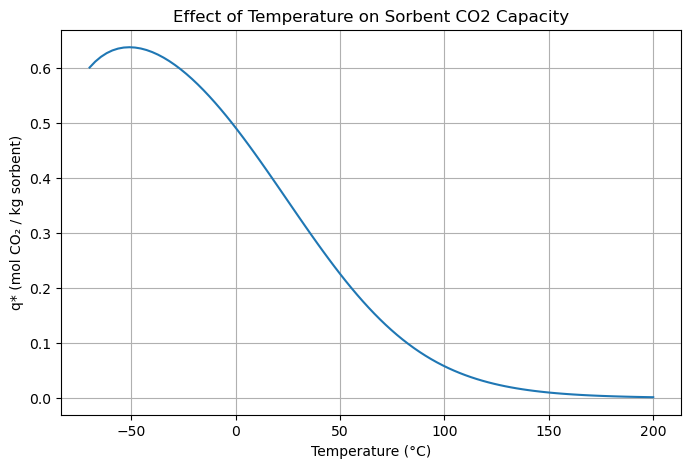

In [220]:
# Plotting T
T_range = np.linspace(203.15, 473.15, 100)  # from 0°C to 100°C
q_vs_T = [find_q_star(0.04, T) for T in T_range]  # 400 ppm CO2

plt.figure(figsize=(8, 5))
plt.plot(T_range - 273.15, q_vs_T)
plt.xlabel("Temperature (°C)")
plt.ylabel("q* (mol CO₂ / kg sorbent)")
plt.title("Effect of Temperature on Sorbent CO2 Capacity")
plt.grid(True)
plt.show()

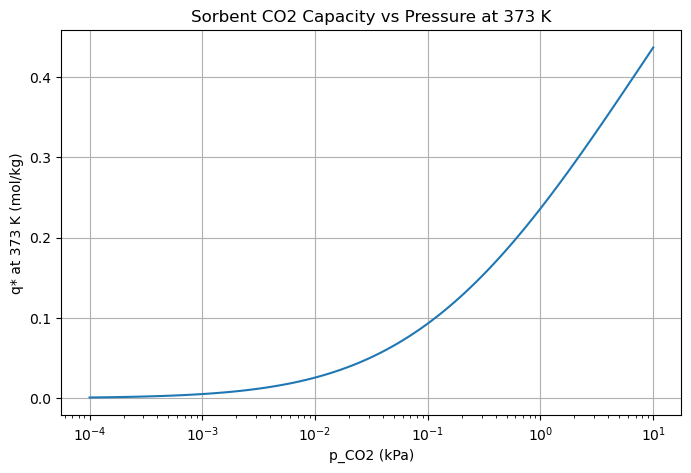

In [221]:
pressures = np.logspace(-4, 1, 100)  # from 0.0001 to 1.0 kPa
q_des_curve = [find_q_star(p, 373.15) for p in pressures]

plt.figure(figsize=(8, 5))
plt.plot(pressures, q_des_curve)
plt.xscale('log')
plt.xlabel("p_CO2 (kPa)")
plt.ylabel("q* at 373 K (mol/kg)")
plt.title("Sorbent CO2 Capacity vs Pressure at 373 K")
plt.grid(True)
plt.show()

In [222]:
# Transport Variables
Dm = 1.5e-5  # m2/s molecular diffusivity
D_TRI = 6e-7 # m2/s TRI-al diffusivity
tau = 3 # tortuosity

Re = rho_c * v * w1 / mu_c # Reynolds number 
Sc = mu_c / (rho_c * Dm) # Schmidt number

rc = 3.5e-10 # m crystalline radius Wefers & Misra 1987
ks = 15 * D_TRI / (rc**2)  # 1/s

# Monolith:
a = 4*w1 / (w2**2 - w1**2)
Sh = 2.696 * (1 + 0.139 * (w1 / L) * Re * Sc) ** 0.81 # Sherwood number
kf_prime = Dm / w1 * Sh # 1/s2
kf = 4 * w1 / (w2**2 - w1**2) * kf_prime  # 1/s

De_m = omega * D_TRI + (1 - omega) * Dm # m2/s

r1 = 2 * w1 / np.pi
r2 = np.sqrt((4 * w_wall * w2 / np.pi) + r1**2)
kp = (24 * De_m * r1) / ((r2 - r1)**2 * (5 * r2 + 3 * r1)) # 1/s

DL = Dm + (v**2 * w1**2) / (192 * Dm)  # m2/s

qv_star = q_star_ads * rho_bed * omega # mol/m3 (mol/kg * kg/m3)
qv_star_c = q_star_ads_c * rho_bed * omega # mol/m3 (mol/kg * kg/m3)

k_inv = (1 / kf) * (qv_star_c / c_CO2_c) + (1 / kp) * (qv_star_c / c_CO2_c) + (1 / ks)
k = 1/k_inv

epsilon_p = 0.71
epsilon_star = epsilon + epsilon_p * (1-epsilon)

In [134]:
# Coupled PDE: Monolith

def q_star_func(c_val):
    p_CO2 = c_val * R_mol * Tc / 1000  # mol/m3 to kPa
    q_mass = find_q_star(p_CO2, Tc)  # mol/kg
    return q_mass * rho_bed * omega # mol/m3

nx = 100 # number of spatial points
dx = L / nx
mesh = Grid1D(dx=dx, nx=nx) # use 1D grid to align with paper assumption


# Variables
c = CellVariable(name="Gas Concentration", mesh=mesh, value=0.0) # mol/m3 Gas phase concentration: initially 0 everywhere
q = CellVariable(name="Solid Loading", mesh=mesh, value=0.0) # mol/m3 Solid phase concentration: initially 0 everywhere


# Inlet CO2 concentration (mol/m3)
c_in = (pCO2_air * 1000) / (R_mol * Tc) # mol/m3

# Boundary conditions: Serna-Guerro paper
c.constrain(c_in, mesh.facesLeft) # CO2 inlet value fixed at ambient
c.faceGrad.constrain(0.0, mesh.facesRight) # zero concentration gradient at outlet

v_vector = FaceVariable(mesh=mesh, rank=1, value=v)

# PDE
mass_balance = (TransientTerm(coeff=epsilon_star, var=c)
                == DiffusionTerm(coeff=epsilon * DL, var=c)
                - ConvectionTerm(coeff=v_vector, var=c)
                - (1 - epsilon_star) * TransientTerm(var=q))


# Time loop
dt = 0.001
steps = 1000
x = mesh.cellCenters.value[0]
c_hist = [] # gas-phase CO2 concentration over time
q_hist = [] # solid-phase CO2 loading over time
time_hist = []
kg_hist   = [] # cumulative kg CO2 in column at each saved step
qgram_hist = [] # mmol/g profile snapshots (same cadence as c_hist)
occ_hist  = [] # average pore occupancy % snapshots


for step in range(steps):
    mass_balance.solve(var=c, dt=dt)
    q_star_val = q_star_func(c.value)
    q.setValue(q.value + k * (q_star_val - q.value) * dt)

    q_vol = q.value # mol/m3 CO2 in every cell
    mol_column = np.trapz(q_vol, x) * np.pi * r**2 # mol CO2 in whole column
    kg_column  = mol_column * 44.01 / 1000 # kg CO2
    kg_hist.append(kg_column)

    if step % 100 == 0:
        q_gram  = q_vol / rho_bed # mmol/g (mol/m3 / kg/m3 = mol/kg)
        qgram_hist.append(q_gram.copy())
        
        q_star_profile = q_star_func(c.value)
        occ_frac = (q_vol / q_star_profile) * 100 # pore occupancy %
        occ_hist.append(occ_frac.mean())

        c_hist.append(c.value.copy())
        q_hist.append(q.value.copy())
        time_hist.append(step * dt)

In [135]:
#np.savez('Mon_SR.npz',q=q.value,c=c.value,c_hist=c_hist,q_hist=q_hist,time_hist=time_hist,kg_hist=kg_hist,qgram_hist=qgram_hist,occ_hist=occ_hist,x=x)
data_short = np.load('Mon_SR.npz')
q = data_short['q']
c = data_short['c']
q_hist = data_short['q_hist']
c_hist = data_short['c_hist']
time_hist = data_short['time_hist']
kg_hist = data_short['kg_hist']
qgram_hist = data_short['qgram_hist']
occ_hist = data_short['occ_hist']
x = data_short['x']

In [136]:
# Courant–Friedrichs–Lewy (CFL) condition check
CFL = max(v * dt / dx, k * 2 * dt / dx**2)
print(f"CFL = {CFL:.4f}")


CFL = 0.2000


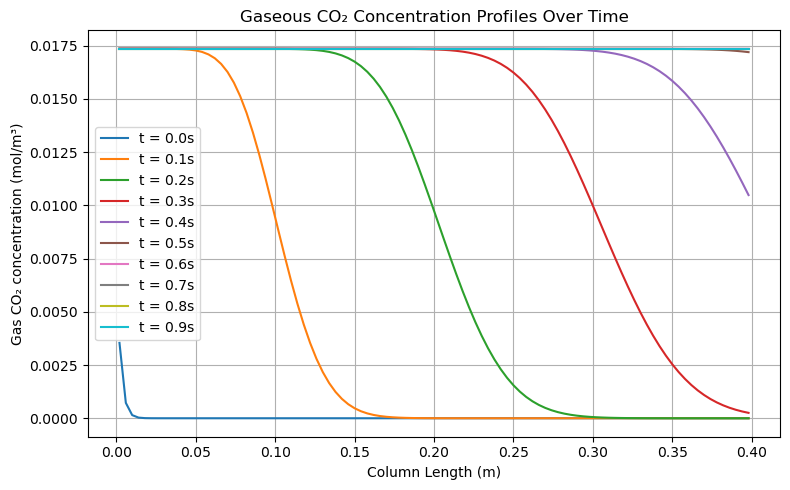

In [137]:
# c breakthrough profiles
plt.figure(figsize=(8, 5))
for i, time in enumerate(time_hist):
    plt.plot(x, c_hist[i], label=f't = {time:.1f}s')
plt.xlabel("Column Length (m)")
plt.ylabel("Gas CO₂ concentration (mol/m³)")
plt.title("Gaseous CO₂ Concentration Profiles Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


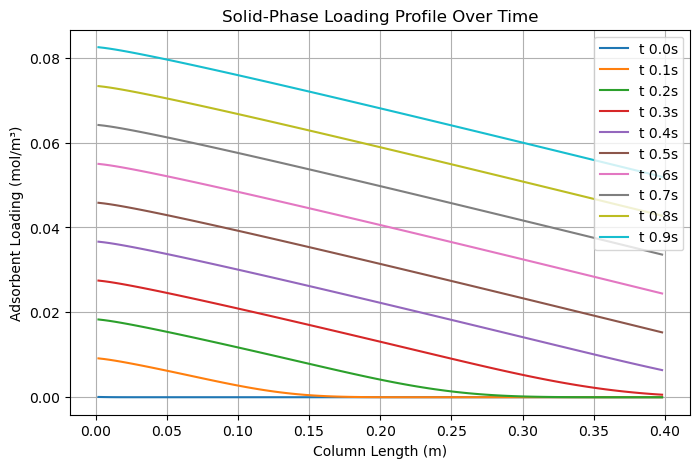

In [138]:
# q breakthrough profiles
plt.figure(figsize=(8, 5))
for i, profile in enumerate(q_hist):
    plt.plot(x, profile, label=f't {i*dt*100:.1f}s')
plt.xlabel("Column Length (m)")
plt.ylabel("Adsorbent Loading (mol/m³)")
plt.title("Solid-Phase Loading Profile Over Time")
plt.legend()
plt.grid(True)
plt.show()


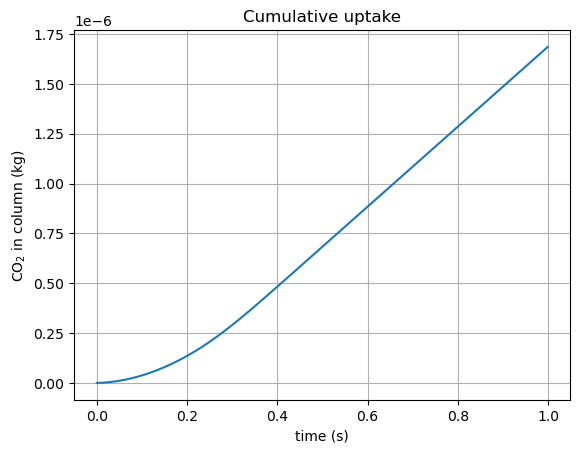

In [139]:
# Cumulative kg CO2 vs time
t_fine = np.arange(steps) * dt        
plt.figure() 
plt.plot(t_fine, kg_hist)
plt.xlabel("time (s)")
plt.ylabel("CO$_2$ in column (kg)")
plt.title("Cumulative uptake")
plt.grid(True)


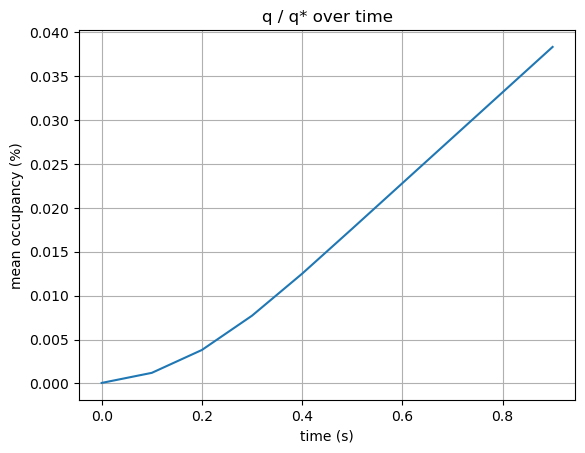

In [140]:
# Average pore-occupancy vs time
plt.figure()
plt.plot(time_hist, occ_hist)
plt.xlabel("time (s)")
plt.ylabel("mean occupancy (%)")
plt.title("q / q* over time")
plt.grid(True)


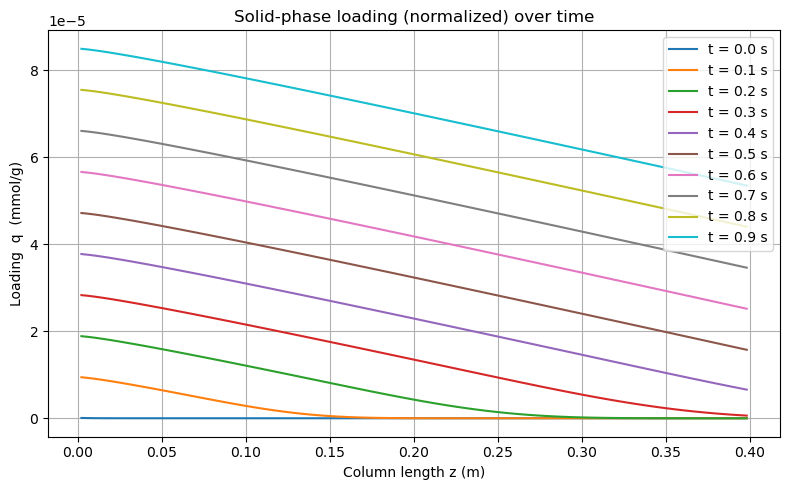

In [141]:
plt.figure(figsize=(8, 5))
for i, (profile_mm, t_snap) in enumerate(zip(qgram_hist, time_hist)):
    plt.plot(x, profile_mm, label=f't = {t_snap:.1f} s')
plt.xlabel("Column length z (m)")
plt.ylabel("Loading  q  (mmol/g)")
plt.title("Solid-phase loading (normalized) over time")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [122]:
# Coupled PDE: Long Adsorption

nxA= 20 # number of spatial points
dxA = L / nxA
meshA = Grid1D(dx=dxA, nx=nxA) # use 1D grid to align with paper assumption


# Variables
cA = CellVariable(name="Gas Concentration", mesh=meshA, value=0.0) # mol/m3 Gas phase concentration: initially 0 everywhere
qA = CellVariable(name="Solid Loading", mesh=meshA, value=0.0) # mol/m3 Solid phase concentration: initially 0 everywhere


# Inlet CO2 concentration (mol/m3)
c_in = (pCO2_air * 1000) / (R_mol * Tc) # mol/m3

# Boundary conditions: Serna-Guerro paper
cA.constrain(c_in, meshA.facesLeft) # CO2 inlet value fixed at ambient
cA.faceGrad.constrain(0.0, meshA.facesRight) # zero concentration gradient at outlet

v_vectorA = FaceVariable(mesh=meshA, rank=1, value=v)

# PDE
mass_balanceA = (TransientTerm(coeff=epsilon_star, var=cA)
                == DiffusionTerm(coeff=epsilon * DL, var=cA)
                - ConvectionTerm(coeff=v_vectorA, var=cA)
                - (1 - epsilon_star) * TransientTerm(var=qA))


# Time loop
dtA = 0.025
stepsA = 400000 #10,000 seconds adsorption time
xA = meshA.cellCenters.value[0]
c_histA = [] # gas-phase CO2 concentration over time
q_histA = [] # solid-phase CO2 loading over time
time_histA = []
kg_histA   = [] # cumulative kg CO2 in column at each saved step
qgram_histA = [] # mmol/g profile snapshots (same cadence as c_hist)
occ_histA  = [] # average pore occupancy % snapshots


for step in range(stepsA):
    mass_balanceA.solve(var=cA, dt=dtA)
    q_star_valA = q_star_func(cA.value)
    qA.setValue(qA.value + k * (q_star_valA - qA.value) * dtA)

    if step % 1000 == 0:
        q_volA = qA.value # mol/m3 CO2 in every cell
        mol_columnA = np.trapz(q_volA, xA) * np.pi * r**2 # mol CO2 in whole column
        kg_columnA  = mol_columnA * 44.01 / 1000 # kg CO2
        kg_histA.append(kg_columnA)
        
        q_gramA  = q_volA / rho_bed # mmol/g (mol/m3 / kg/m3 = mol/kg)
        qgram_histA.append(q_gramA.copy())
        
        q_star_profileA = q_star_func(cA.value)
        occ_fracA = (q_volA / q_star_profileA) * 100 # pore occupancy %
        occ_histA.append(occ_fracA.mean())

        c_histA.append(cA.value.copy())
        q_histA.append(qA.value.copy())
        time_histA.append(step * dtA)

In [123]:
# Courant–Friedrichs–Lewy (CFL) condition check
CFL_A = max(v * dtA / dxA, k * 2 * dtA / dxA**2)
print(f"CFL = {CFL_A:.4f}")


CFL = 1.0000


In [142]:
#np.savez('Mon_long_adsorptionA.npz',q=q.value,c=c.value,c_hist=c_hist,q_hist=q_hist,time_hist=time_hist,kg_hist=kg_hist,qgram_hist=qgram_hist,occ_hist=occ_hist,x=x)
data_long = np.load('Mon_long_adsorptionA.npz')
qA = data_long['q']
cA = data_long['c']
q_histA = data_long['q_hist']
c_histA = data_long['c_hist']
time_histA = data_long['time_hist']
kg_histA = data_long['kg_hist']
qgram_histA = data_long['qgram_hist']
occ_histA = data_long['occ_hist']
xA = data_long['x']

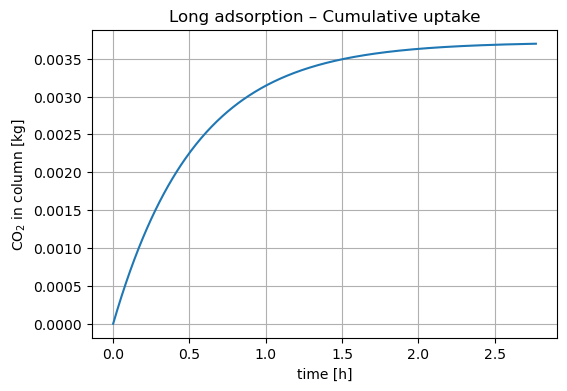

In [143]:
# Cumulative kg CO2 vs time
plt.figure(figsize=(6,4))
plt.plot(np.array(time_histA)/3600, kg_histA)
plt.xlabel("time [h]")
plt.ylabel("CO$_2$ in column [kg]")
plt.title("Long adsorption – Cumulative uptake")
plt.grid(True)

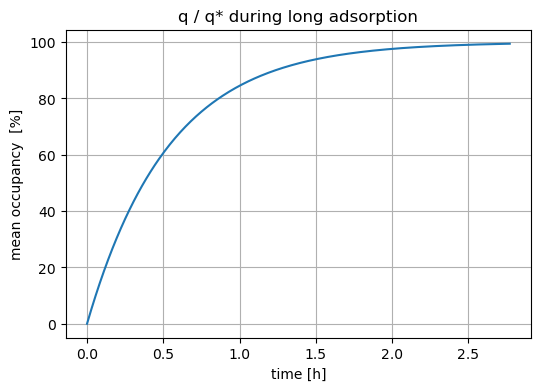

In [144]:
# Average pore-occupancy vs time
plt.figure(figsize=(6,4))
plt.plot(np.array(time_histA)/3600, occ_histA)
plt.xlabel("time [h]")
plt.ylabel("mean occupancy  [%]")
plt.title("q / q* during long adsorption")
plt.grid(True)


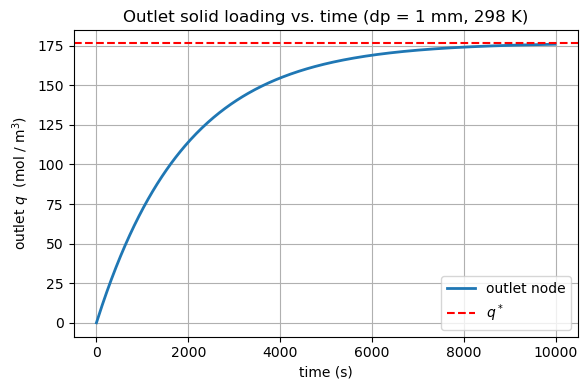

In [145]:
# Outlet node loading vs time
q_out  = np.array([profile[-1] for profile in q_histA])   # last cell = outlet
time_s = np.array(time_histA)
q_star_valA = q_star_func(cA)

plt.figure(figsize=(6,4))
plt.plot(time_s, q_out, lw=2, label="outlet node")

plt.axhline(q_star_valA[-1], ls="--", c="red", label=r"$q^*$")

plt.xlabel("time (s)")
plt.ylabel(r"outlet $q$  (mol / m$^{3}$)")
plt.title("Outlet solid loading vs. time (dp = 1 mm, 298 K)")
plt.legend(); plt.grid(True); plt.tight_layout()

In [127]:
# Coupled PDE: Long Adsorption

nxB= 20 # number of spatial points
dxB = L / nxB
meshB = Grid1D(dx=dxB, nx=nxB) # use 1D grid to align with paper assumption


# Variables
cB = CellVariable(name="Gas Concentration", mesh=meshB, value=0.0) # mol/m3 Gas phase concentration: initially 0 everywhere
qB = CellVariable(name="Solid Loading", mesh=meshB, value=0.0) # mol/m3 Solid phase concentration: initially 0 everywhere


# Inlet CO2 concentration (mol/m3)
c_in = (pCO2_air * 1000) / (R_mol * Tc) # mol/m3

# Boundary conditions: Serna-Guerro paper
cB.constrain(c_in, meshB.facesLeft) # CO2 inlet value fixed at ambient
cB.faceGrad.constrain(0.0, meshB.facesRight) # zero concentration gradient at outlet

v_vectorB = FaceVariable(mesh=meshB, rank=1, value=v)

# PDE
mass_balanceB = (TransientTerm(coeff=epsilon_star, var=cB)
                == DiffusionTerm(coeff=epsilon * DL, var=cB)
                - ConvectionTerm(coeff=v_vectorB, var=cB)
                - (1 - epsilon_star) * TransientTerm(var=qB))


# Time loop
dtB = 0.025
stepsB = 144000 #3,600 seconds adsorption time (1 hour)
xB = meshB.cellCenters.value[0]
c_histB = [] # gas-phase CO2 concentration over time
q_histB = [] # solid-phase CO2 loading over time
time_histB = []
kg_histB   = [] # cumulative kg CO2 in column at each saved step
qgram_histB = [] # mmol/g profile snapshots (same cadence as c_hist)
occ_histB  = [] # average pore occupancy % snapshots


for step in range(stepsB):
    mass_balanceB.solve(var=cB, dt=dtB)
    q_star_valB = q_star_func(cB.value)
    qB.setValue(qB.value + k * (q_star_valB - qB.value) * dtB)

    if step % 5000 == 0:
        q_volB = qB.value # mol/m3 CO2 in every cell
        mol_columnB = np.trapz(q_volB, xB) * np.pi * r**2 # mol CO2 in whole column
        kg_columnB  = mol_columnB * 44.01 / 1000 # kg CO2
        kg_histB.append(kg_columnB)
        
        q_gramB  = q_volB / rho_bed # mmol/g (mol/m3 / kg/m3 = mol/kg)
        qgram_histB.append(q_gramB.copy())
        
        q_star_profileB = q_star_func(cB.value)
        occ_fracB = (q_volB / q_star_profileB) * 100 # pore occupancy %
        occ_histB.append(occ_fracB.mean())

        c_histB.append(cB.value.copy())
        q_histB.append(qB.value.copy())
        time_histB.append(step * dtB)

In [128]:
# Courant–Friedrichs–Lewy (CFL) condition check
nxB= 20 # number of spatial points
dxB = L / nxB
dtB = 0.025
CFL_B = max(v * dtB / dxB, k * 2 * dtB / dxB**2)
print(f"CFL = {CFL_B:.4f}")

CFL = 1.0000


In [146]:
#np.savez('Mon_long_adsorptionB.npz',q=q.value,c=c.value,c_hist=c_hist,q_hist=q_hist,time_hist=time_hist,kg_hist=kg_hist,qgram_hist=qgram_hist,occ_hist=occ_hist,x=x)
data_longB = np.load('Mon_long_adsorptionB.npz')
qB = data_longB['q']
cB = data_longB['c']
q_histB = data_longB['q_hist']
c_histB = data_longB['c_hist']
time_histB = data_longB['time_hist']
kg_histB = data_longB['kg_hist']
qgram_histB = data_longB['qgram_hist']
occ_histB = data_longB['occ_hist']
xB = data_longB['x']

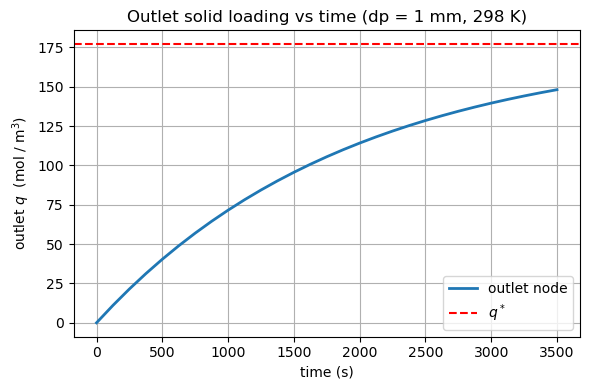

In [147]:
# Outlet node loading vs time
q_out  = np.array([profile[-1] for profile in q_histB])   # last cell = outlet
time_s = np.array(time_histB)
q_star_valB = q_star_func(cB)

plt.figure(figsize=(6,4))
plt.plot(time_s, q_out, lw=2, label="outlet node")

plt.axhline(q_star_valB[-1], ls="--", c="red", label=r"$q^*$")

plt.xlabel("time (s)")
plt.ylabel(r"outlet $q$  (mol / m$^{3}$)")
plt.title("Outlet solid loading vs time (dp = 1 mm, 298 K)")
plt.legend(); plt.grid(True); plt.tight_layout()

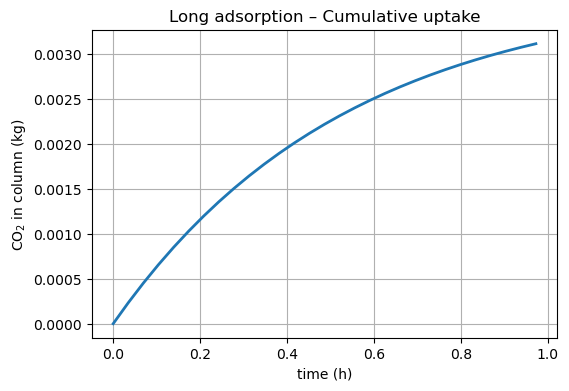

In [148]:
# Cumulative kg CO2 vs time
plt.figure(figsize=(6,4))
plt.plot(np.array(time_histB)/3600, kg_histB, lw=2)
plt.xlabel("time (h)")
plt.ylabel("CO$_2$ in column (kg)")
plt.title("Long adsorption – Cumulative uptake")
plt.grid(True)

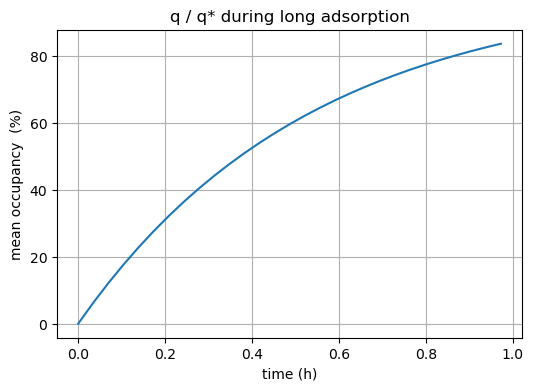

In [149]:
# Average pore-occupancy vs time
plt.figure(figsize=(6,4))
plt.plot(np.array(time_histB)/3600, occ_histB)
plt.xlabel("time (h)")
plt.ylabel("mean occupancy  (%)")
plt.title("q / q* during long adsorption")
plt.grid(True)

In [227]:
# Desorption Process 
# Calculate new 'k'
dpore = 14e-9 # m
DK_d = (dpore/3.0) * np.sqrt(8*R_mol*Twf/(np.pi*0.044009)) # Knudsen Diffusivity
D_TRI_d = DK_d/3 # where 3 is the tortiousity (Sabatino & Stampi-Bombelli)
De_p_d = D_TRI_d  # m2/s Effective pore diffusivity in TRI-al during desorption

Dm_d = Dm * (Twf / Tc)**1.5 * (pH / pL)  # m2/s molecular diffusivity during desorption 
v_d = 0.0 # m/s during desorption
u_d = v_d / epsilon # m/s interstitial velocity during desorption

rho_d = CP.PropsSI('D','P',pL,'T',Twf,'air') #kg/m3 constant density
mu_d = CP.PropsSI('V','P',pL,'T',Twf,'air') #Pa*s constant viscosity
Re_d = rho_d * v_d * w1 / mu_d # Reynolds number
Sc_d = mu_d / (rho_d * Dm_d) # Schmidt number

ks = 10**4 # assumed for now, Stampi-Bombelli

Sh_d = 2.696 * (1 + 0.139 * (w1 / L) * Re_d * Sc_d) ** 0.81 # Sherwood number
kf_prime_d = Dm_d / w1 * Sh_d # m/s
kf_d = 4 * w1 / (w2**2 - w1**2) * kf_prime_d  # 1/s

De_m_d = omega * D_TRI_d + (1 - omega) * Dm_d # m2/s

kp_d = (24 * De_m_d * r1) / ((r2 - r1)**2 * (5 * r2 + 3 * r1)) # 1/s

qv_star_d = q_star_des * rho_bed # mol/m3 (mol/kg * kg/m3)
c_CO2_d = (pCO2_des * 1000) / (R_mol * Twf) # mol/m3 

k_inv_d = (1 / kf_d) * (qv_star_d / c_CO2_d) + (1 / kp_d) * (qv_star_d / c_CO2_d) + (1 / ks)
k_d = 1/k_inv_d

print(k, k_d)


6.81346831283419e-06 0.0002154483006610174


In [151]:
# Coupled PDE: Desorption from full

nx_d = 100 # number of spatial points
dx_d = L / nx_d
mesh_d = Grid1D(dx=dx_d, nx=nx_d) # use 1D grid to align with paper assumption


# Variables
c_d = CellVariable(name="Gas Concentration", mesh=mesh_d, value=0.0) # mol/m3 Gas phase concentration: initially 0 everywhere
q_d = CellVariable(name="Solid Loading", mesh=mesh_d, value=q_star_mon_c) # mol/m3 Solid phase concentration: initially full everywhere


# Inlet CO2 concentration (mol/m3)
c_in_des = (pCO2_des * 1000) / (R_mol * Twf) # mol/m3 

# Boundary conditions: Serna-Guerro paper
c_d.constrain(c_in_des, mesh_d.facesRight) # CO2 air value fixed 1kPa vacuum
c_d.faceGrad.constrain(0.0, mesh_d.facesLeft) # zero concentration gradient at outlet


# PDE
mass_balance_d = (TransientTerm(coeff=epsilon_star, var=c_d)
                == DiffusionTerm(coeff=epsilon * Dm_d, var=c_d)
                - (1 - epsilon_star) * TransientTerm(var=q_d))


# Time loop
dt_d = 0.001
steps_d = 1000
x_d = mesh_d.cellCenters.value[0]
c_hist_d = [] # gas-phase CO2 concentration over time
q_hist_d = [] # solid-phase CO2 loading over time
time_hist_d = []


for step in range(steps_d):
    mass_balance_d.solve(var=c_d, dt=dt_d)
    q_d.setValue(q_d.value + k_d * (q_star_des - q_d.value) * dt_d)

    if step % 100 == 0:
        c_hist_d.append(c_d.value.copy())
        q_hist_d.append(q_d.value.copy())
        time_hist_d.append(step * dt_d)
        

In [152]:
# np.savez(
#     "Mon_desorb.npz",
#     q=q_d.value,
#     c=c_d.value,
#     c_hist=c_hist_d,
#     q_hist=q_hist_d,
#     time_hist=time_hist_d,
#     x=x_d,
# )

data_des = np.load('Mon_desorb.npz')
q_d = data_des['q'] # final solid loading profile
c_d = data_des['c'] # final gas concentration profile
q_hist_d = data_des['q_hist'] # time history of q profiles
c_hist_d = data_des['c_hist'] # time history of c profiles
time_hist_d = data_des['time_hist'] # time stamps
x_d = data_des['x'] # spatial grid


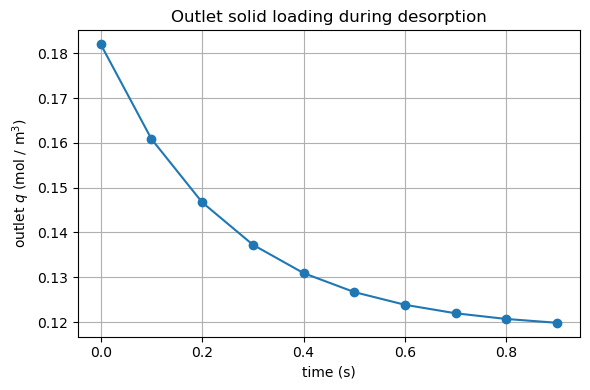

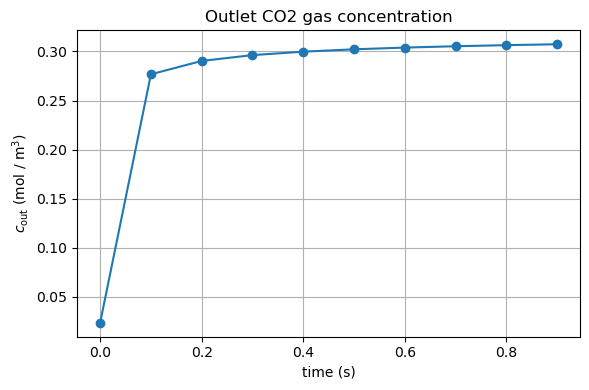

In [153]:
time_arr   = np.array(time_hist_d)
q_out_arr  = np.array([q[-1] for q in q_hist_d]) # outlet cell, mol/m3
c_out_arr = np.array([c[-1] for c in c_hist_d])

# outlet solid loading
plt.figure(figsize=(6,4))
plt.plot(time_arr, q_out_arr, marker='o')
plt.xlabel('time (s)')
plt.ylabel(r'outlet $q$ (mol / m$^{3}$)')
plt.title('Outlet solid loading during desorption')
plt.grid(True); plt.tight_layout()

# CO2 gas concentration at outlet
plt.figure(figsize=(6,4))
plt.plot(time_arr, c_out_arr, marker='o')
plt.xlabel('time (s)')
plt.ylabel(r'$c_{\mathrm{out}}$ (mol / m$^{3}$)')
plt.title('Outlet CO2 gas concentration')
plt.grid(True); plt.tight_layout()


In [155]:
# Coupled PDE: Desorption from full longer time

nx_dA = 20
dx_dA = L / nx_dA
mesh_dA = Grid1D(dx=dx_dA, nx=nx_dA)

c_dA = CellVariable(name="Gas Concentration", mesh=mesh_dA, value=0.0)
q_dA = CellVariable(name="Solid Loading", mesh=mesh_dA, value=q_star_mon_c)

c_in_des = (pCO2_des * 1000) / (R_mol * Twf) # mol/m3 

c_dA.constrain(c_in_des, mesh_dA.facesRight)
c_dA.faceGrad.constrain(0.0, mesh_dA.facesLeft)

mass_balance_dA = (TransientTerm(coeff=epsilon_star, var=c_dA)
                == DiffusionTerm(coeff=epsilon * Dm_d, var=c_dA)
                - (1 - epsilon_star) * TransientTerm(var=q_dA))

dt_dA = 0.025
steps_dA = 4800 # 2 minutes desorption
x_dA = mesh_dA.cellCenters.value[0]

c_hist_dA = []
q_hist_dA = []
time_hist_dA = []

for step in range(steps_dA):
    mass_balance_dA.solve(var=c_dA, dt=dt_dA)
    q_dA.setValue(q_dA.value + k_d * (q_star_des - q_dA.value) * dt_dA)

    if step % 100 == 0:
        c_hist_dA.append(c_dA.value.copy())
        q_hist_dA.append(q_dA.value.copy())
        time_hist_dA.append(step * dt_dA)

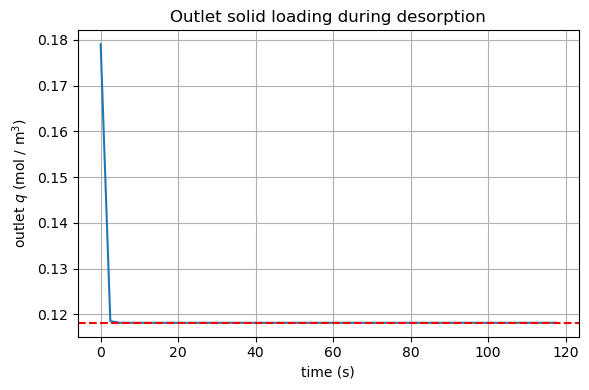

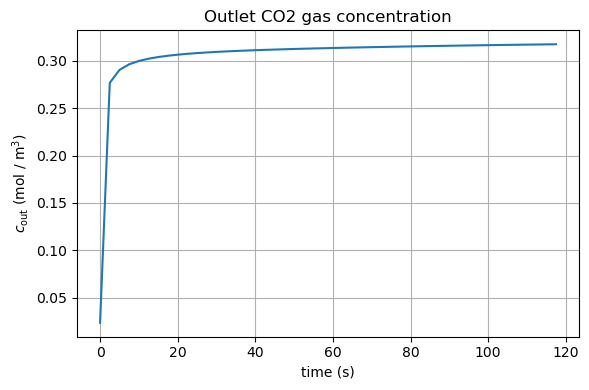

In [156]:
time_arrA   = np.array(time_hist_dA)
q_out_arrA  = np.array([qA[-1] for qA in q_hist_dA]) # outlet cell, mol/m3
c_out_arrA = np.array([cA[-1] for cA in c_hist_dA])

# outlet solid loading
plt.figure(figsize=(6,4))
plt.plot(time_arrA, q_out_arrA)
plt.axhline(q_star_des, ls="--", c="red", label=r"$q^*$")
plt.xlabel('time (s)')
plt.ylabel(r'outlet $q$ (mol / m$^{3}$)')
plt.title('Outlet solid loading during desorption')
plt.grid(True); plt.tight_layout()

# CO2 gas concentration at outlet
plt.figure(figsize=(6,4))
plt.plot(time_arrA, c_out_arrA)
plt.xlabel('time (s)')
plt.ylabel(r'$c_{\mathrm{out}}$ (mol / m$^{3}$)')
plt.title('Outlet CO2 gas concentration')
plt.grid(True); plt.tight_layout()

In [157]:
# Coupled PDE: Desorption from where adsorption B left off

nx_dB = 20
dx_dB = L / nx_dB
mesh_dB = Grid1D(dx=dx_dB, nx=nx_dB)

c_dB = CellVariable(name="Gas Concentration", mesh=mesh_dB, value=0.0)
q_dB = CellVariable(name="Solid Loading", mesh=mesh_dB, value=np.mean(q_histB[-1]))

c_in_des = (pCO2_des * 1000) / (R_mol * Twf) # mol/m3 

c_dB.constrain(c_in_des, mesh_dB.facesRight)
c_dB.faceGrad.constrain(0.0, mesh_dB.facesLeft)

mass_balance_dB = (TransientTerm(coeff=epsilon_star, var=c_dB)
                == DiffusionTerm(coeff=epsilon * Dm_d, var=c_dB)
                - (1 - epsilon_star) * TransientTerm(var=q_dB))

dt_dB = 0.025
steps_dB = 4800 # 2 minutes desorption
x_dB = mesh_dB.cellCenters.value[0]

c_hist_dB = []
q_hist_dB = []
time_hist_dB = []

for step in range(steps_dB):
    mass_balance_dB.solve(var=c_dB, dt=dt_dB)
    q_dB.setValue(q_dB.value + k_d * (q_star_des - q_dB.value) * dt_dB)

    if step % 100 == 0:
        c_hist_dB.append(c_dB.value.copy())
        q_hist_dB.append(q_dB.value.copy())
        time_hist_dB.append(step * dt_dB)

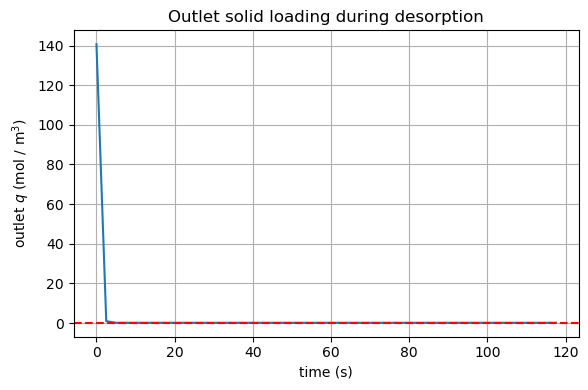

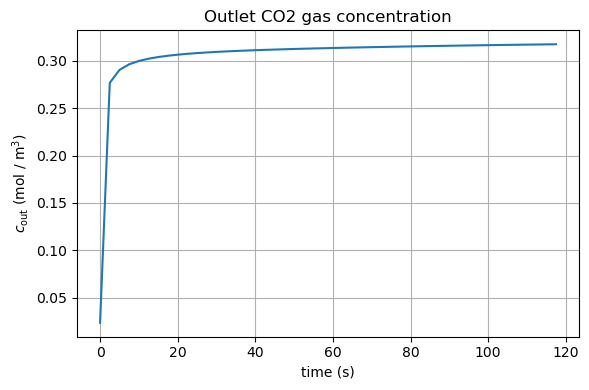

In [158]:
time_arrB  = np.array(time_hist_dB)
q_out_arrB  = np.array([qB[-1] for qB in q_hist_dB]) # outlet cell, mol/m3
c_out_arrB = np.array([cB[-1] for cB in c_hist_dB])

# outlet solid loading
plt.figure(figsize=(6,4))
plt.plot(time_arrB, q_out_arrB)
plt.axhline(q_star_des, ls="--", c="red", label=r"$q^*$")
plt.xlabel('time (s)')
plt.ylabel(r'outlet $q$ (mol / m$^{3}$)')
plt.title('Outlet solid loading during desorption')
plt.grid(True); plt.tight_layout()

# CO2 gas concentration at outlet
plt.figure(figsize=(6,4))
plt.plot(time_arrB, c_out_arrB)
plt.xlabel('time (s)')
plt.ylabel(r'$c_{\mathrm{out}}$ (mol / m$^{3}$)')
plt.title('Outlet CO2 gas concentration')
plt.grid(True); plt.tight_layout()


In [183]:
# Energy requirement calculations 10 min ads, 10 min des:
cap10_df = pd.read_csv("captureMon_10min.csv")
kgCO2_10series  = pd.Series(cap10_df.kg_CO2.values, index=cap10_df.Temp_K.astype(int))

records_10 = []
for T_ran in range(270,322,2):
    
    mu   = CP.PropsSI('V', 'T', T_ran, 'P', pH, 'air')
    rho  = CP.PropsSI('D', 'T', T_ran, 'P', pH, 'air')
    
    t_fan = 600 # s, 10 min step 1
    t_comp1 = 50 # s, 50 from step 2
    t_heat = 600 # s, 10 min step 3
    t_comp2 = t_heat # s, step 3 vacuum pulling CO2 during desorption

    V_air = epsilon * V # m3, volume of air in packed bed (free space)
    area_air = V_air / L
    V_flow = area_air * v  # m3/s, Volumetric flow rate of gas
    m_air = rho * V_air # kg, mass of air in PB
    n_air = m_air / t_comp1  # kg/s, gas flow rate: mass of air / run time of vacuum pump

    m_CO2 = kgCO2_10series.loc[T_ran] # kg
    pCO2 = m_CO2 * R_CO2 * Twf/ V_air # Pa, partial pressure of CO2
    n_CO2 = m_CO2 / t_comp2 # kg/s, CO2 gas flow rate

    # Pressure Drop: Hagen-Poiseuille Equation for rectangular channels
    P_drop = (32 * L * mu * u) / (w1**2)
    
    # Calculate work
    fanWork = fan_work(eta_fan, V_flow, P_drop, t_fan)
    compWork1 = comp_work(eta_comp, n_air, R, T_ran, pH, pL, t_comp1)
    compWork2 = comp_work(eta_comp, n_CO2, R_CO2, Twf, pCO2, pL, t_comp2)
    compWork = compWork1 + compWork2
    elecwork = total_work(compWork, fanWork)

    # Calculate heat transfer
    Q = heat_transfer(h_W, Twf, T_ran, r, L, t_heat)

    records_10.append(dict(Fan_work = fanWork, Comp_work1 = compWork1, Comp_work2 = compWork2, Heat = Q))
    
df_10 = pd.DataFrame(records_10)
print(df_10)


FileNotFoundError: [Errno 2] No such file or directory: 'captureMon_10min.csv'

In [111]:
# Energy requirement calculations 20 min ads, 20 min des:
cap20_df = pd.read_csv("captureMon_20min.csv")
kgCO2_20series  = pd.Series(cap20_df.kg_CO2.values, index=cap20_df.Temp_K.astype(int))

records_20 = []
for T_ran in range(270,322,2):
    
    mu   = CP.PropsSI('V', 'T', T_ran, 'P', pH, 'air')
    rho  = CP.PropsSI('D', 'T', T_ran, 'P', pH, 'air')
    
    t_fan = 1200 # s
    t_comp1 = 50 # s
    t_heat = 1200 # s
    t_comp2 = t_heat # s, step 3 vacuum pulling CO2 during desorption

    V_air = epsilon * V # m3, volume of air in packed bed (free space)
    area_air = V_air / L
    V_flow = area_air * v  # m3/s, Volumetric flow rate of gas
    m_air = rho * V_air # kg, mass of air in PB
    n_air = m_air / t_comp1  # kg/s, gas flow rate: mass of air / run time of vacuum pump

    m_CO2 = kgCO2_20series.loc[T_ran] # kg
    pCO2 = m_CO2 * R_CO2 * Twf/ V_air # Pa, partial pressure of CO2
    n_CO2 = m_CO2 / t_comp2 # kg/s, CO2 gas flow rate

    # Pressure Drop: Hagen-Poiseuille Equation for rectangular channels
    P_drop = (32 * L * mu * u) / (w1**2)
    
    # Calculate work
    fanWork = fan_work(eta_fan, V_flow, P_drop, t_fan)
    compWork1 = comp_work(eta_comp, n_air, R, T_ran, pH, pL, t_comp1)
    compWork2 = comp_work(eta_comp, n_CO2, R_CO2, Twf, pCO2, pL, t_comp2)
    compWork = compWork1 + compWork2
    elecwork = total_work(compWork, fanWork)

    # Calculate heat transfer
    Q = heat_transfer(h_W, Twf, T_ran, r, L, t_heat)

    records_20.append(dict(Fan_work = fanWork, Comp_work1 = compWork1, Comp_work2 = compWork2, Heat = Q))
    
df_20 = pd.DataFrame(records_20)
print(df_20)


     Fan_work  Comp_work1  Comp_work2          Heat
0   83.258034  609.546863  196.090814  43553.029930
1   83.748538  609.530761  193.887613  42708.569825
2   84.237577  609.515123  191.688608  41864.109720
3   84.725162  609.499932  189.493837  41019.649614
4   85.211306  609.485175  188.398051  40175.189509
5   85.696018  609.470837  186.209703  39330.729404
6   86.179309  609.456902  184.025687  38486.269298
7   86.661191  609.443359  181.846043  37641.809193
8   87.141674  609.430195  179.670812  36797.349088
9   87.620768  609.417396  178.584864  35952.888983
10  88.098485  609.404951  176.416331  35108.428877
11  88.574833  609.392849  174.252317  34263.968772
12  89.049825  609.381079  172.092866  33419.508667
13  89.523469  609.369630  169.938022  32575.048561
14  89.995777  609.358492  168.862343  31730.588456
15  90.466757  609.347655  166.714496  30886.128351
16  90.936419  609.337109  164.571373  30041.668246
17  91.404774  609.326847  162.433022  29197.208140
18  91.87183

In [113]:
# Energy requirement calculations 30 min ads, 30 min des:
cap30_df = pd.read_csv("captureMon_30min.csv")
kgCO2_30series  = pd.Series(cap30_df.kg_CO2.values, index=cap30_df.Temp_K.astype(int))

records_30 = []
for T_ran in range(270,322,2):
    
    mu   = CP.PropsSI('V', 'T', T_ran, 'P', pH, 'air')
    rho  = CP.PropsSI('D', 'T', T_ran, 'P', pH, 'air')
    
    t_fan = 1800 # s
    t_comp1 = 50 # s
    t_heat = 1800 # s
    t_comp2 = t_heat # s, step 3 vacuum pulling CO2 during desorption

    V_air = epsilon * V # m3, volume of air in packed bed (free space)
    area_air = V_air / L
    V_flow = area_air * v  # m3/s, Volumetric flow rate of gas
    m_air = rho * V_air # kg, mass of air in PB
    n_air = m_air / t_comp1  # kg/s, gas flow rate: mass of air / run time of vacuum pump

    m_CO2 = kgCO2_30series.loc[T_ran] # kg
    pCO2 = m_CO2 * R_CO2 * Twf/ V_air # Pa, partial pressure of CO2
    n_CO2 = m_CO2 / t_comp2 # kg/s, CO2 gas flow rate

    # Pressure Drop: Hagen-Poiseuille Equation for rectangular channels
    P_drop = (32 * L * mu * u) / (w1**2)
    
    # Calculate work
    fanWork = fan_work(eta_fan, V_flow, P_drop, t_fan)
    compWork1 = comp_work(eta_comp, n_air, R, T_ran, pH, pL, t_comp1)
    compWork2 = comp_work(eta_comp, n_CO2, R_CO2, Twf, pCO2, pL, t_comp2)
    compWork = compWork1 + compWork2
    elecwork = total_work(compWork, fanWork)

    # Calculate heat transfer
    Q = heat_transfer(h_W, Twf, T_ran, r, L, t_heat)

    records_30.append(dict(Fan_work = fanWork, Comp_work1 = compWork1, Comp_work2 = compWork2, Heat = Q))
    
df_30 = pd.DataFrame(records_30)
print(df_30)

      Fan_work  Comp_work1  Comp_work2          Heat
0   124.887050  609.546863  322.844900  65329.544895
1   125.622806  609.530761  319.260558  64062.854737
2   126.356365  609.515123  316.874521  62796.164579
3   127.087744  609.499932  313.300796  61529.474421
4   127.816959  609.485175  309.733518  60262.784263
5   128.544026  609.470837  306.172749  58996.094105
6   129.268964  609.456902  303.802547  57729.403948
7   129.991786  609.443359  300.252758  56462.713790
8   130.712511  609.430195  296.709641  55196.023632
9   131.431152  609.417396  293.173259  53929.333474
10  132.147727  609.404951  289.643677  52662.643316
11  132.862250  609.392849  286.120962  51395.953158
12  133.574738  609.381079  283.776333  50129.263000
13  134.285204  609.369630  280.265213  48862.572842
14  134.993665  609.358492  276.761142  47595.882684
15  135.700135  609.347655  272.100138  46329.192526
16  136.404629  609.337109  268.612796  45062.502368
17  137.107162  609.326847  265.132747  43795.

In [115]:
# Energy requirement calculations 1 hr ads, 1 hr des:
cap1h_df = pd.read_csv("captureMon_1hr.csv")
kgCO2_1hseries  = pd.Series(cap1h_df.kg_CO2.values, index=cap1h_df.Temp_K.astype(int))

records_1h = []
for T_ran in range(270,322,2):
    
    mu   = CP.PropsSI('V', 'T', T_ran, 'P', pH, 'air')
    rho  = CP.PropsSI('D', 'T', T_ran, 'P', pH, 'air')
    
    t_fan = 3600 # s
    t_comp1 = 50 # s
    t_heat = 3600 # s
    t_comp2 = t_heat # s, step 3 vacuum pulling CO2 during desorption

    V_air = epsilon * V # m3, volume of air in packed bed (free space)
    area_air = V_air / L
    V_flow = area_air * v  # m3/s, Volumetric flow rate of gas
    m_air = rho * V_air # kg, mass of air in PB
    n_air = m_air / t_comp1  # kg/s, gas flow rate: mass of air / run time of vacuum pump

    m_CO2 = kgCO2_1hseries.loc[T_ran] # kg
    pCO2 = m_CO2 * R_CO2 * Twf/ V_air # Pa, partial pressure of CO2
    n_CO2 = m_CO2 / t_comp2 # kg/s, CO2 gas flow rate

    # Pressure Drop: Hagen-Poiseuille Equation for rectangular channels
    P_drop = (32 * L * mu * u) / (w1**2)
    
    # Calculate work
    fanWork = fan_work(eta_fan, V_flow, P_drop, t_fan)
    compWork1 = comp_work(eta_comp, n_air, R, T_ran, pH, pL, t_comp1)
    compWork2 = comp_work(eta_comp, n_CO2, R_CO2, Twf, pCO2, pL, t_comp2)
    compWork = compWork1 + compWork2
    elecwork = total_work(compWork, fanWork)

    # Calculate heat transfer
    Q = heat_transfer(h_W, Twf, T_ran, r, L, t_heat)

    records_1h.append(dict(Fan_work = fanWork, Comp_work1 = compWork1, Comp_work2 = compWork2, Heat = Q))
    
df_1h = pd.DataFrame(records_1h)
print(df_1h)

      Fan_work  Comp_work1  Comp_work2           Heat
0   249.774101  609.546863  711.847773  130659.089790
1   251.245613  609.530761  703.770920  128125.709474
2   252.712730  609.515123  695.707410  125592.329159
3   254.175487  609.499932  688.998103  123058.948843
4   255.633917  609.485175  680.959388  120525.568527
5   257.088053  609.470837  672.934385  117992.188211
6   258.537927  609.456902  664.923226  115458.807895
7   259.983573  609.443359  656.926051  112925.427579
8   261.425021  609.430195  648.942999  110392.047263
9   262.862304  609.417396  639.647478  107858.666948
10  264.295454  609.404951  631.695519  105325.286632
11  265.724500  609.392849  622.436679  102791.906316
12  267.149475  609.381079  613.197934  100258.526000
13  268.570408  609.369630  603.979533   97725.145684
14  269.987330  609.358492  593.469455   95191.765368
15  271.400270  609.347655  584.295514   92658.385052
16  272.809258  609.337109  573.836944   90125.004737
17  274.214323  609.326847  

In [202]:
print(w_wall*1000, kp, kf)
print()
print(Sh, Re, Sc)

# Temporarily made loading 100% kp: 0.4777621777372998
# bloading = 10% kp: 10.797425216862978

1.25 10.797425216862978 35.31604539833952

2.759066046745275 64.25502154033595 1.0375323993132088


In [184]:
print(Dm, D_TRI, De_m)

print()
print(w2, w1)

1.5e-05 6e-07 6e-07

0.0025 0.00125


In [223]:

# Range of wall size ratios (w1/w2)
ratios = np.linspace(0.3, 0.9, 7)  # 7 evenly spaced points between 0.3 and 0.9

print("omega = 0.1")
print("w1/w2 ratio | wall thickness (mm) | kp (1/s)")
print("-----------------------------------------------")

for ratio in ratios:
    w1 = ratio * w2  # channel width
    w_wall = w2 - w1  # wall thickness
    r1 = 2 * w1 / np.pi
    r2 = np.sqrt((4 * w_wall * w2 / np.pi) + r1**2)
    kp = (24 * De_m * r1) / ((r2 - r1)**2 * (5 * r2 + 3 * r1))
    print(f"{ratio:8.2f} | {w_wall*1000:18.3f} | {kp:10.4e}")


omega = 0.1
w1/w2 ratio | wall thickness (mm) | kp (1/s)
-----------------------------------------------
    0.30 |              1.750 | 3.0947e+00
    0.40 |              1.500 | 5.8011e+00
    0.50 |              1.250 | 1.0797e+01
    0.60 |              1.000 | 2.0959e+01
    0.70 |              0.750 | 4.5062e+01
    0.80 |              0.500 | 1.2028e+02
    0.90 |              0.250 | 5.6265e+02


In [239]:
print("omega = 1.0")
print("w1/w2 ratio | wall thickness (mm) | kp (1/s)")
print("-----------------------------------------------")

for ratio in ratios:
    w1 = ratio * w2  # channel width
    w_wall = w2 - w1  # wall thickness
    r1 = 2 * w1 / np.pi
    r2 = np.sqrt((4 * w_wall * w2 / np.pi) + r1**2)
    kp = (24 * De_m * r1) / ((r2 - r1)**2 * (5 * r2 + 3 * r1))
    print(f"{ratio:8.2f} | {w_wall*1000:18.3f} | {kp:10.4e}")

omega = 1.0
w1/w2 ratio | wall thickness (mm) | kp (1/s)
-----------------------------------------------
    0.30 |              1.750 | 1.3693e-01
    0.40 |              1.500 | 2.5668e-01
    0.50 |              1.250 | 4.7776e-01
    0.60 |              1.000 | 9.2741e-01
    0.70 |              0.750 | 1.9939e+00
    0.80 |              0.500 | 5.3221e+00
    0.90 |              0.250 | 2.4896e+01


In [185]:
print(k)
# half as quick as the packed bed

0.0005181394072401557


In [187]:
print(rho_p,V,V_wall)

1283.619188191882 0.000502654824574367 0.00038015482457436696


In [229]:
print(w_wall*1000)

1.75


In [230]:
print(qv_star_c*V*1000)
print(qv_star_d*V*1000)

174.49684046456932
113.11222696051627


In [233]:
print(qv_star_c, qv_star_d)

347.15043392317585 225.02962556123143


In [237]:
print(174.5-113.1)

61.400000000000006
